# Sea Ice Concentration in OND Data Processing from CESM2-LE
- Process data for Southern Ocean SIC in OND (for phyto)
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- July 2025

## October, November, December average SIC

- Start of phytoplankton growth in spring, what is ice concentration.

In [1]:
import utils
import xarray as xr
import numpy as np
import dask
from distributed import Client
from ncar_jobqueue import NCARCluster
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Spin up DASK cluster

In [2]:
# Create our NCAR Cluster - which uses PBSCluster under the hood
cluster = NCARCluster(walltime='2:00:00', cores=1, processes=1, memory='100 GB', 
                      resource_spec='select=1:ncpus=1:mem=100GB',interface='ext')

# Spin up 32 workers
cluster.scale(32)

# Assign the cluster to our Client
client = Client(cluster)

In [3]:
client
# cluster.close()

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.173:37951,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Define some functions we'll need to load data

In [4]:
# define the metrics we can load 
metrics_dict = {
    "SIC": ['aice'],
}

def get_metrics_list():
    return list(metrics_dict.keys())

In [5]:
# function to return the variables we need to return for all metrics
def get_metric_variable(metric):
    var_names = metrics_dict[metric]
    # handle the case where there is only one variable
    if isinstance(var_names, str):
        return var_names
    # handle the case where there are multiple variables
    else:
        return var_names[:]

In [6]:
# function to average over top 150m for relevant variables and to keep time bound
def preprocess(ds):
    tb = ds.time_bounds    
    #re-write time bound with saved value
    ds['time_bound'] = tb
    return ds

In [7]:
# function for loading datasets
def load_datasets(varnames, experiment,lat_min,lat_max):
    ds_list = []
    for varname in varnames:
        subset = catalog.search(component='ice',
                                variable=varname,
                                experiment=experiment,
                                forcing_variant='cmip6',
                               )
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):
            dsets = subset.to_dataset_dict()
        ds = dsets[f'ice.{experiment}.cice.h.cmip6.{varname}'] 
        
        # compute time mean to get correct months
        ds['time']= ds.time_bounds.compute().mean(dim="d2")
        # keep only some variables
        keep_vars=['time_bounds','TLAT','TLON','tarea','time'] + [varname]
        ds = ds.drop([v for v in ds.variables if v not in keep_vars])
        ds_list.append(ds)
        ds = xr.merge(ds_list, compat="override")
        
        # crop data to the latitudes we want, use given lat/lon, not specific indices
        #ds = ds.isel(nlat=slice(0,37)) # Crop to Southern Ocean, ind_start = 0, ind_end = 37
        ds = ds.where(((ds['TLAT'] <= lat_max) & (ds['TLAT'] >= lat_min)), drop=True)
        
    return ds

## Select the metric you are interested in

In [8]:
import utils

In [9]:
## Print out potential metrics to investigate:
metrics_list = get_metrics_list()
print(metrics_list)

['SIC']


In [10]:
## Enter the metric  of interest:
metric = 'SIC'

In [11]:
## Enter the years you want to keep:
yy_st = "1950"
yy_ed = "2100"

In [12]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

## Load CESM2-LE data

In [13]:
# for the metric supplied, define the list of required variable names
varnames = get_metric_variable(metric) 
varnames

['aice']

### Load the Data Catalog

In [14]:
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

### Load historical data

In [15]:
%%time
# load historical
ds_hist = load_datasets(varnames,'historical',lat_min,lat_max)
ds_hist


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 15.1 s, sys: 505 ms, total: 15.6 s
Wall time: 29 s


<xarray.Dataset>
Dimensions:      (nj: 36, ni: 320, time: 1980, d2: 2, member_id: 50)
Coordinates:
    TLON         (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT         (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
  * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: nj, ni, d2, member_id
Data variables:
    tarea        (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    time_bounds  (time, d2, nj, ni) object dask.array<chunksize=(120, 2, 36, 320), meta=np.ndarray>
    aice         (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 120, 36, 320), meta=np.ndarray>
Attributes:
    time_period_freq:        month_1
    comment:                 All years have exactly 365 days
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    comment3:                seconds elapsed into model date:      0
    contents:                Diagnostic and Prognostic Variables
    history:                 This dataset was created on 2020-02-01 at 05:49\...
    intake_esm_varname:      ['aice']
    io_flavor:               io_pio
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    conventions:             CF-1.0
    comment2:                File written on model date 20100201
    intake_esm_dataset_key:  ice.historical.cice.h.cmip6.aice

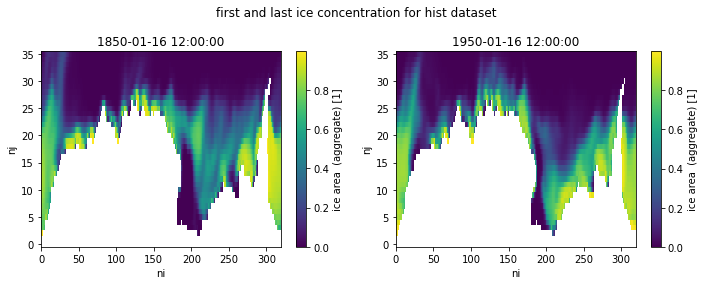

In [16]:
# check that this data looks reasonable

mem_5_hist = ds_hist.aice.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_hist.isel(time=0).plot(ax=ax1)
ax1.set_title(mem_5_hist.isel(time=0).time.values)

mem_5_hist.isel(time=1200).plot(ax=ax2)
ax2.set_title(mem_5_hist.isel(time=1200).time.values)

fig.suptitle("first and last ice concentration for hist dataset")

plt.tight_layout()
plt.show()

### Load future data

In [17]:
%%time
# load future
ds_ssp = load_datasets(varnames, 'ssp370',lat_min,lat_max)
ds_ssp


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 6.66 s, sys: 112 ms, total: 6.78 s
Wall time: 8.34 s


<xarray.Dataset>
Dimensions:      (nj: 36, ni: 320, time: 1032, d2: 2, member_id: 50)
Coordinates:
    TLON         (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT         (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: nj, ni, d2, member_id
Data variables:
    tarea        (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    time_bounds  (time, d2, nj, ni) object dask.array<chunksize=(120, 2, 36, 320), meta=np.ndarray>
    aice         (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 120, 36, 320), meta=np.ndarray>
Attributes:
    time_period_freq:        month_1
    comment:                 All years have exactly 365 days
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    comment3:                seconds elapsed into model date:      0
    contents:                Diagnostic and Prognostic Variables
    history:                 This dataset was created on 2020-04-29 at 18:54\...
    intake_esm_varname:      ['aice']
    io_flavor:               io_pio
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    conventions:             CF-1.0
    comment2:                File written on model date 20950201
    intake_esm_dataset_key:  ice.ssp370.cice.h.cmip6.aice

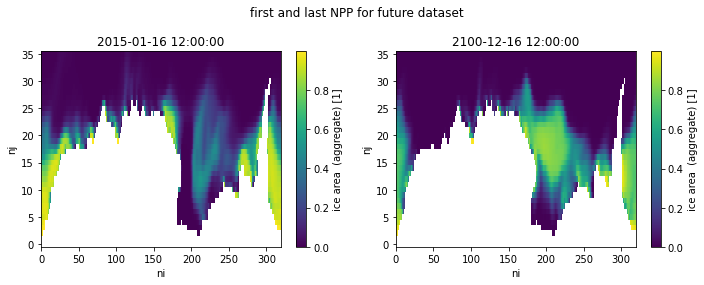

In [18]:
# check that this data looks reasonable

mem_5_ssp = ds_ssp.aice.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_ssp.isel(time=0).plot(ax=ax1)
ax1.set_title(mem_5_ssp.isel(time=0).time.values)

mem_5_ssp.isel(time=-1).plot(ax=ax2)
ax2.set_title(mem_5_ssp.isel(time=-1).time.values)

fig.suptitle("first and last NPP for future dataset")

plt.tight_layout()
plt.show()

## Concatenate historical and future datasets and crop to just the times we need


In [19]:
ds = xr.concat((ds_hist, ds_ssp),dim='time')
ds.time

<xarray.DataArray 'time' (time: 3012)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00

In [20]:
#rename dimensions
ds = ds.rename({'nj':'nlat','ni': 'nlon'})

In [21]:
ds

<xarray.Dataset>
Dimensions:      (time: 3012, nlat: 36, nlon: 320, d2: 2, member_id: 50)
Coordinates:
    TLON         (nlat, nlon) float32 320.6 321.7 322.8 ... 317.2 318.3 319.4
    TLAT         (nlat, nlon) float32 -79.22 -79.22 -79.22 ... -60.52 -60.52
  * time         (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: nlat, nlon, d2, member_id
Data variables:
    tarea        (time, nlat, nlon) float32 dask.array<chunksize=(1980, 36, 320), meta=np.ndarray>
    time_bounds  (time, d2, nlat, nlon) object dask.array<chunksize=(120, 2, 36, 320), meta=np.ndarray>
    aice         (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 120, 36, 320), meta=np.ndarray>
Attributes:
    time_period_freq:        month_1
    comment:                 All years have exactly 365 days
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    comment3:                seconds elapsed into model date:      0
    contents:                Diagnostic and Prognostic Variables
    history:                 This dataset was created on 2020-02-01 at 05:49\...
    intake_esm_varname:      ['aice']
    io_flavor:               io_pio
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    conventions:             CF-1.0
    comment2:                File written on model date 20100201
    intake_esm_dataset_key:  ice.historical.cice.h.cmip6.aice

In [22]:
# keep just years chosen above
ds = ds.sel(time=slice(yy_st, yy_ed))
#ds = ds.isel(time=slice(1200, 3012)) # Cut timeseries to 1950 - 2100: 1812 time steps
ds.time

<xarray.DataArray 'time' (time: 1812)>
array([cftime.DatetimeNoLeap(1950, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1950, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1950, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1950-01-16 12:00:00 ... 2100-12-16 12:00:00

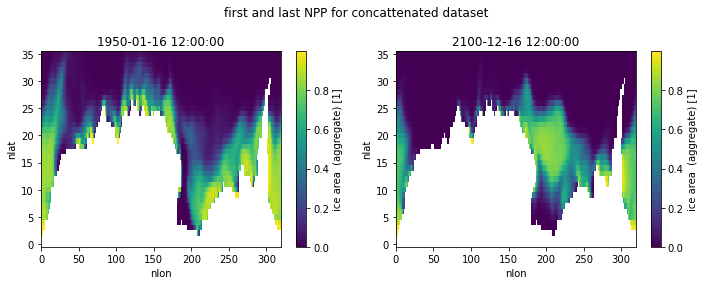

In [23]:
# check that this data looks reasonable

mem_5 = ds.aice.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5.isel(time=0).plot(ax=ax1)
ax1.set_title(mem_5.isel(time=0).time.values)

mem_5.isel(time=-1).plot(ax=ax2)
ax2.set_title(mem_5.isel(time=-1).time.values)

fig.suptitle("first and last NPP for concattenated dataset")

plt.tight_layout()
plt.show()

# Get OND SIC

In [24]:
data = ds['aice']

In [25]:
# Keep OND only
data_keep = data.where(data.time.dt.month >= 10, drop=True)

In [26]:
# get dimensions for calculating annual spring means
# get list of years
dates = data.where(data.time.dt.month == 1, drop = True)
years = dates.time.dt.year

# get dimensions of the grid we need to iterate over
xlen = len(data_keep.nlon)
ylen = len(data_keep.nlat)
dlen = len(years)
mlen = len(data_keep.member_id)
print(xlen,ylen,dlen,mlen)

320 36 151 50


In [27]:
# loop through all years

# make numpy array to fill and specify dimensions
array_avg = np.zeros([mlen,dlen,ylen,xlen])

for yy in years:
    #print('Calculating spring mean for '+str(yy.values))
    # need to specify which spot in the array we'll fill for the decade
    if yy == 1950:
        count = 0
    else: 
        count = count+1  
    # get data subset
    data_sub = data_keep.where(data_keep.time.dt.year == yy.values, drop = True)
    # average across all months for this year
    array_avg[:,count,:,:] = data_sub.mean(dim='time')

# convert to xarray
data_keep_1 = xr.DataArray(array_avg,dims=('member_id','time','nlat','nlon'))
data_keep_1['member_id'] = data_keep.member_id
data_keep_1['time'] = dates.time
data_keep_1['nlat'] = data_keep.nlat
data_keep_1['nlon'] = data_keep.nlon

In [28]:
data_keep = data_keep_1

In [37]:
# reassign time array to match other data we'll use

# Create year array 150 years long: Last year will be 2099
years = np.arange(int(yy_st),int(yy_ed),1)

# drop last year in data
data_keep = data_keep.where(data_keep.time.dt.year < 2100, drop=True)

# reassign time dimension
data_keep['time'] = years

## Put together into one dataset

- Netcdf with variable dimension: (member_id x year x nlat x nlon) Include TLAT and TLONG as coordinates

In [40]:
# load grid data to include in output file
dir_in = '/glade/u/home/duvivier/masks/'
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon

# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

In [41]:
ds_out = xr.Dataset()

ds_out['SIC_OND'] = data_keep

# change the attributes
ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'May sea ice fraction in the Southern Ocean from 1950 to 2099.'

ds_out

<xarray.Dataset>
Dimensions:    (member_id: 50, time: 150, nlat: 36, nlon: 320)
Coordinates:
  * member_id  (member_id) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * time       (time) int64 1950 1951 1952 1953 1954 ... 2096 2097 2098 2099
  * nlat       (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 27 28 29 30 31 32 33 34 35
  * nlon       (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
Data variables:
    SIC_OND    (member_id, time, nlat, nlon) float64 nan nan ... 0.01887 0.01943
Attributes:
    author:          Alice DuVivier
    date_processed:  2025-08-02
    contents:        May sea ice fraction in the Southern Ocean from 1950 to ...

In [42]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")
    

Dimensions:
	member_id: (50,)
	time: (150,)
	nlat: (36,)
	nlon: (320,)
Coordinates:
	member_id:
		[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
	time:
		[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033
 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047
 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061
 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075
 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089
 2090 2091 2092 2093 2094 209

## Export and Save

In [43]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 0.64 GB.


In [44]:
path_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'
file_out = 'CESM2-LE-SIC_OND.nc'
fout = path_out + file_out

In [45]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)

In [46]:
cluster.close()

## Test if it worked

In [47]:
import netCDF4
nc = netCDF4.Dataset(fout)
print(nc.variables)

{'member_id': <class 'netCDF4._netCDF4.Variable'>
int64 member_id(member_id)
unlimited dimensions: 
current shape = (50,)
filling on, default _FillValue of -9223372036854775806 used, 'time': <class 'netCDF4._netCDF4.Variable'>
int64 time(time)
unlimited dimensions: 
current shape = (150,)
filling on, default _FillValue of -9223372036854775806 used, 'nlat': <class 'netCDF4._netCDF4.Variable'>
int64 nlat(nlat)
unlimited dimensions: 
current shape = (36,)
filling on, default _FillValue of -9223372036854775806 used, 'nlon': <class 'netCDF4._netCDF4.Variable'>
int64 nlon(nlon)
unlimited dimensions: 
current shape = (320,)
filling on, default _FillValue of -9223372036854775806 used, 'SIC_OND': <class 'netCDF4._netCDF4.Variable'>
float64 SIC_OND(member_id, time, nlat, nlon)
    _FillValue: nan
unlimited dimensions: 
current shape = (50, 150, 36, 320)
filling on}


In [48]:
path =  path_out
ds_in =  xr.open_dataset(path_out+file_out, decode_times=True)

In [49]:
ds_in.info()

xarray.Dataset {
dimensions:
	member_id = 50 ;
	time = 150 ;
	nlat = 36 ;
	nlon = 320 ;

variables:
	int64 member_id(member_id) ;
	int64 time(time) ;
	int64 nlat(nlat) ;
	int64 nlon(nlon) ;
	float64 SIC_OND(member_id, time, nlat, nlon) ;

// global attributes:
	:author = Alice DuVivier ;
	:date_processed = 2025-08-02 ;
	:contents = May sea ice fraction in the Southern Ocean from 1950 to 2099. ;
}

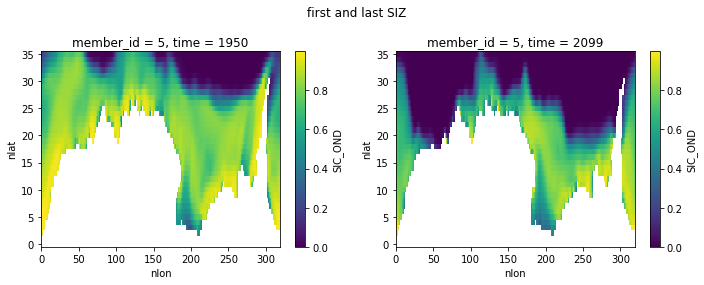

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [50]:
mem_5_ints = ds_in.SIC_OND.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_ints.isel(time=0).plot(ax=ax1)

mem_5_ints.isel(time=-1).plot(ax=ax2)

fig.suptitle("first and last SIZ")

plt.tight_layout()
plt.show()